In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib as mpl

# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,12)))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

runstr='Dry'
dftab=pd.read_pickle('dfs/df_run_02_dry_delta_tab.pkl')
df=pd.read_pickle('dfs/df_run_02_dry.pkl')

runstr='Wet'
dftab=pd.read_pickle('dfs/df_run_02_land_delta_tab.pkl')
df=pd.read_pickle('dfs/df_run _02_land.pkl')

tlfs=df.tlf.unique()

In [45]:
def fit_thalf(t,y,ylab,ax=False):
    ly = np.log(y)
    K, A_log = np.polyfit(t, ly, 1)
    A = np.exp(A_log)
    thalf=-np.log(2)/K
    yf=np.exp(A_log+t*K)
    
    if ax:
        ax.plot(t*24,y)
        ax.plot(t*24,yf,'--')
        ax.grid(True)
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.set_xlabel('t (h)')
        ax.set_ylabel(ylab)
        ax.set_xlim((0,12))        
    return(thalf)

def get_a_coeff(dft,tlf,tmin=1,tmax=3,ax=False,xvar='dPdr'):
#     tal=dft['t']-dft['tlf']
    dft=dft[dft.tlf.eq(tlf) & dft.r.gt(5)]
    dft=dft.query('r < rV10max*1.0')
    dft=dft.query('t - tlf < ' + str(tmax) +'/24.')
    dft=dft.query('t - tlf > ' + str(tmin) +'/24.')
    dft=dft.query('dPdr > 0')
    m,c=np.polyfit(dft[xvar],dft.vrcol,1)
    
    if ax:
        fs=8
        ax.plot(dft[xvar],dft.vrcol,'.')
        ax.plot(dft[xvar],m*dft[xvar]+c,lw=2)
#         ax.set_xlim((0,0.25))
#         ax.set_ylim((0,0.045))
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.grid(True)
        ax.set_xlabel(xvar)
        ax.set_ylabel('vrcol')
        r2=np.corrcoef(dft[xvar],dft.vrcol)[0,1]**2
        ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
    return(m)

def calc_thalf(rmax,a,Pe,P0):
    return(rmax**2/(2*a*Pe)*np.log(1+Pe/(Pe-P0)))

def calc_thalf_sqrtrPd(r0,a,Pe):
    return(0.6666*np.log(2)*np.sqrt(np.sqrt(2))*np.sqrt(r0)/(Pe*a*np.exp(0)))

def calc_thalf_rPd(a,Pe):
    return(np.log(2)/(Pe*a*np.exp(0)))

def plot_ts(ax,d):
    ax.plot(tlfs,d.dat,'x-')
    ax.grid(True)
    ax.set_ylabel(d.lab)
    
class Var:
    def __init__(self,vid,vdat,vlab):
        self.id=vid
        self.dat=vdat
        self.lab=vlab
        
def plot_scat(ax,d):
    ax.plot(d.x.dat,d.y.dat,'x-')
    ax.grid(True)
    ax.set_xlabel(d.x.lab)
    ax.set_ylabel(d.y.lab)
    for tlf,x,y in zip(tlfs,d.x.dat,d.y.dat):
        ax.text(x,y,round(tlf),fontsize=fs)
    r2=np.corrcoef(d.x.dat,d.y.dat)[0,1]**2
    ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
    if d.eq:
        axr=[np.min((d.x.dat,d.y.dat)),np.max((d.x.dat,d.y.dat))]
        axr[0]=axr[0]-0.1*(axr[1]-axr[0])
        axr[1]=axr[1]+0.1*(axr[1]-axr[0])
        ax.plot(axr,axr,':k')
        ax.set_xlim(axr)
        ax.set_ylim(axr)

class Pltdat:
    def __init__(self,x,y,eq):
        self.x=x
        self.y=y
        self.eq=eq

/home/nsparks/anaconda3/envs/itc/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting vars
Calculating half lives
plotting time series
plotting scatters


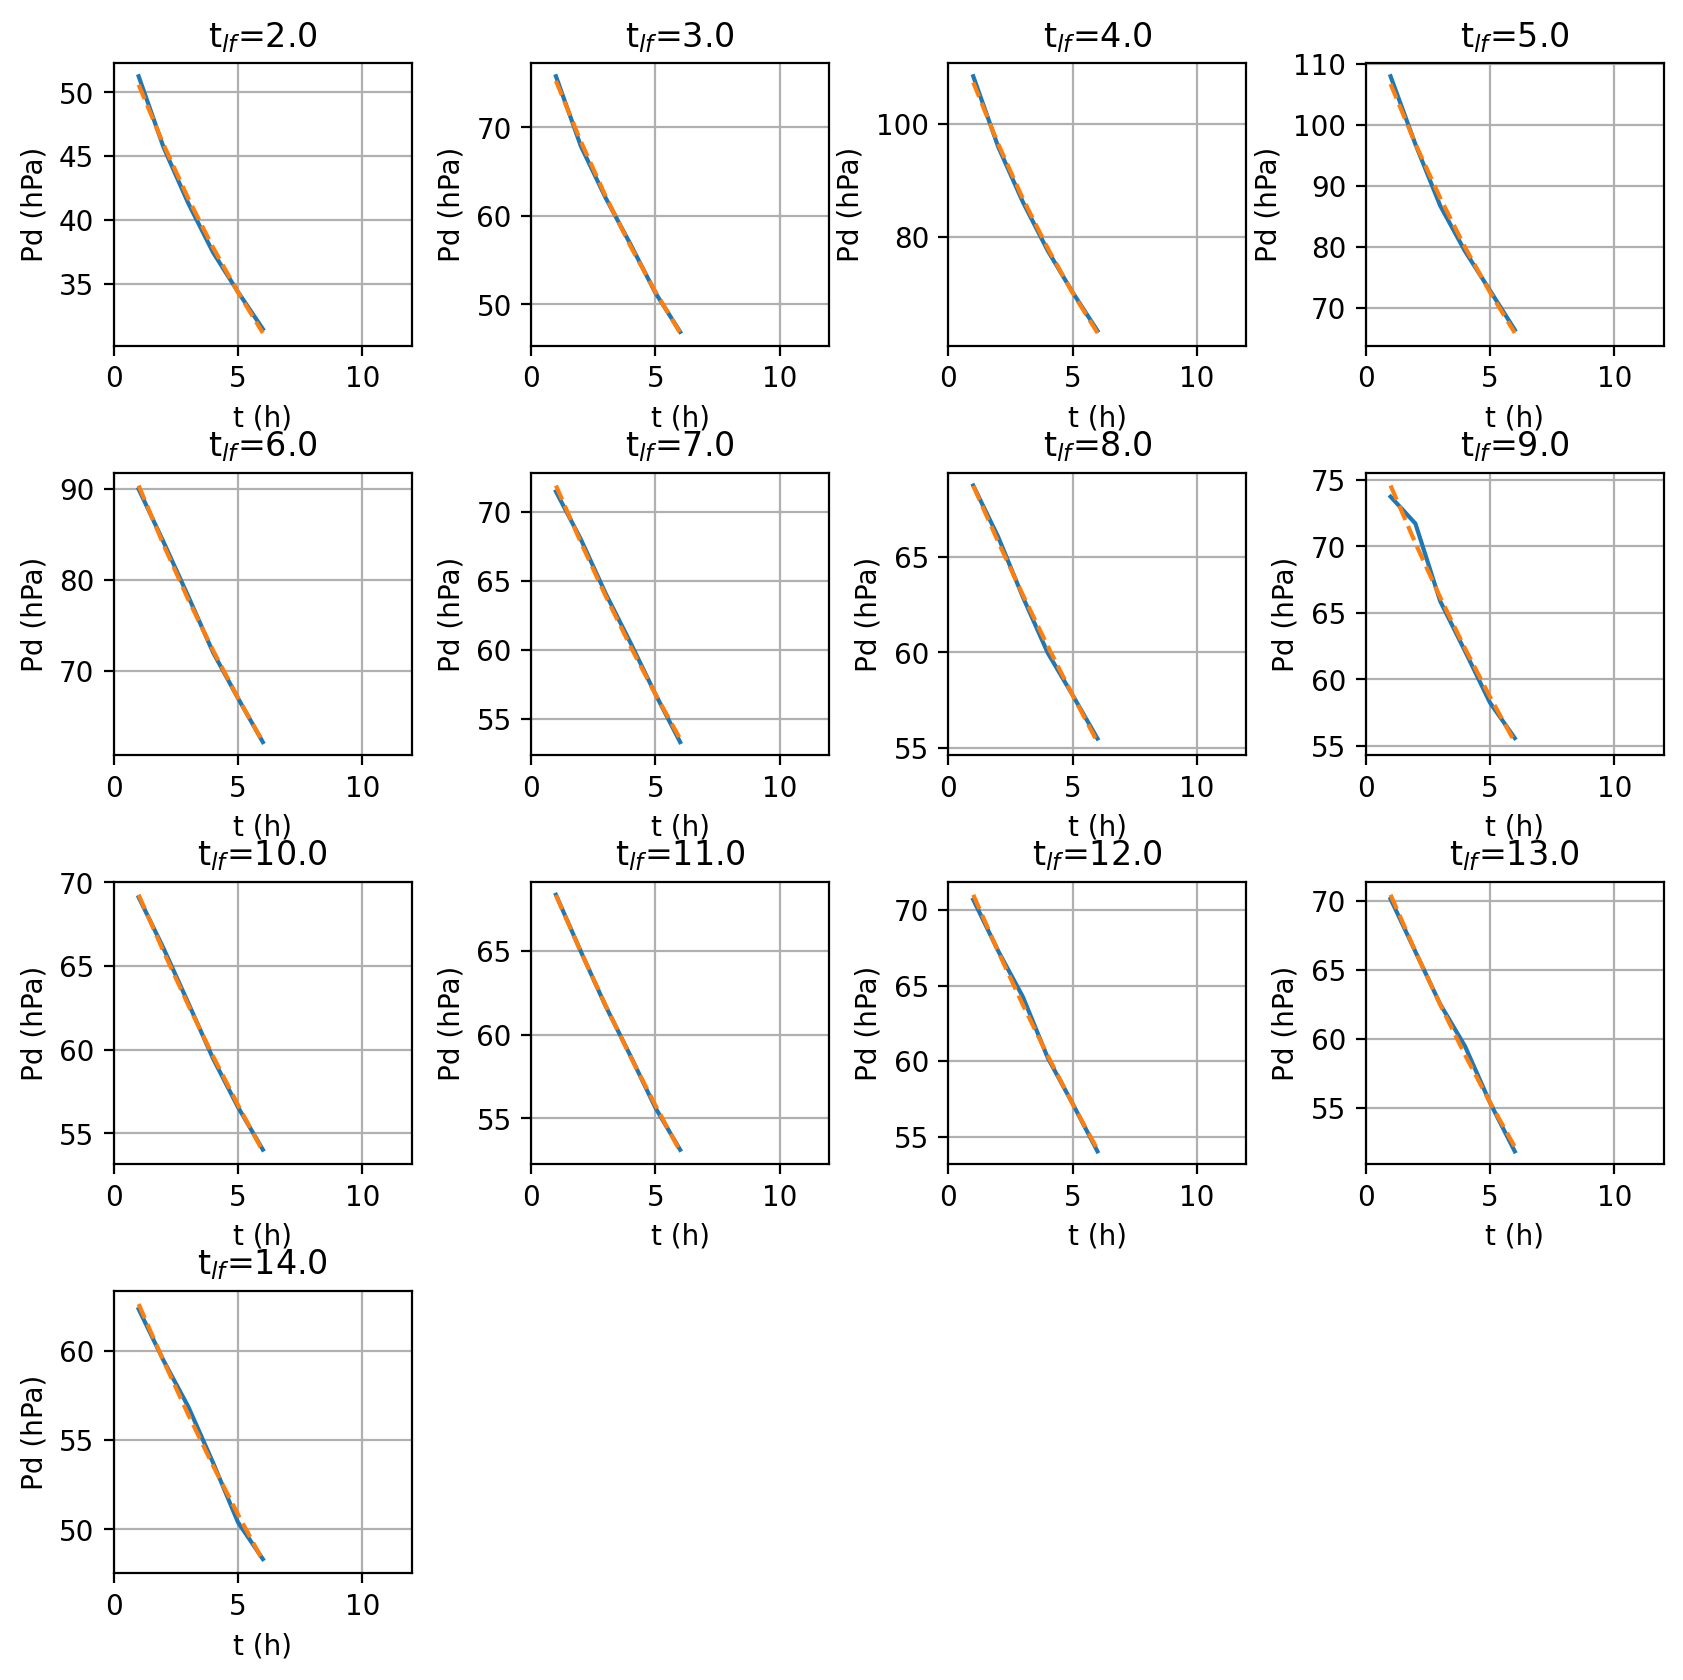

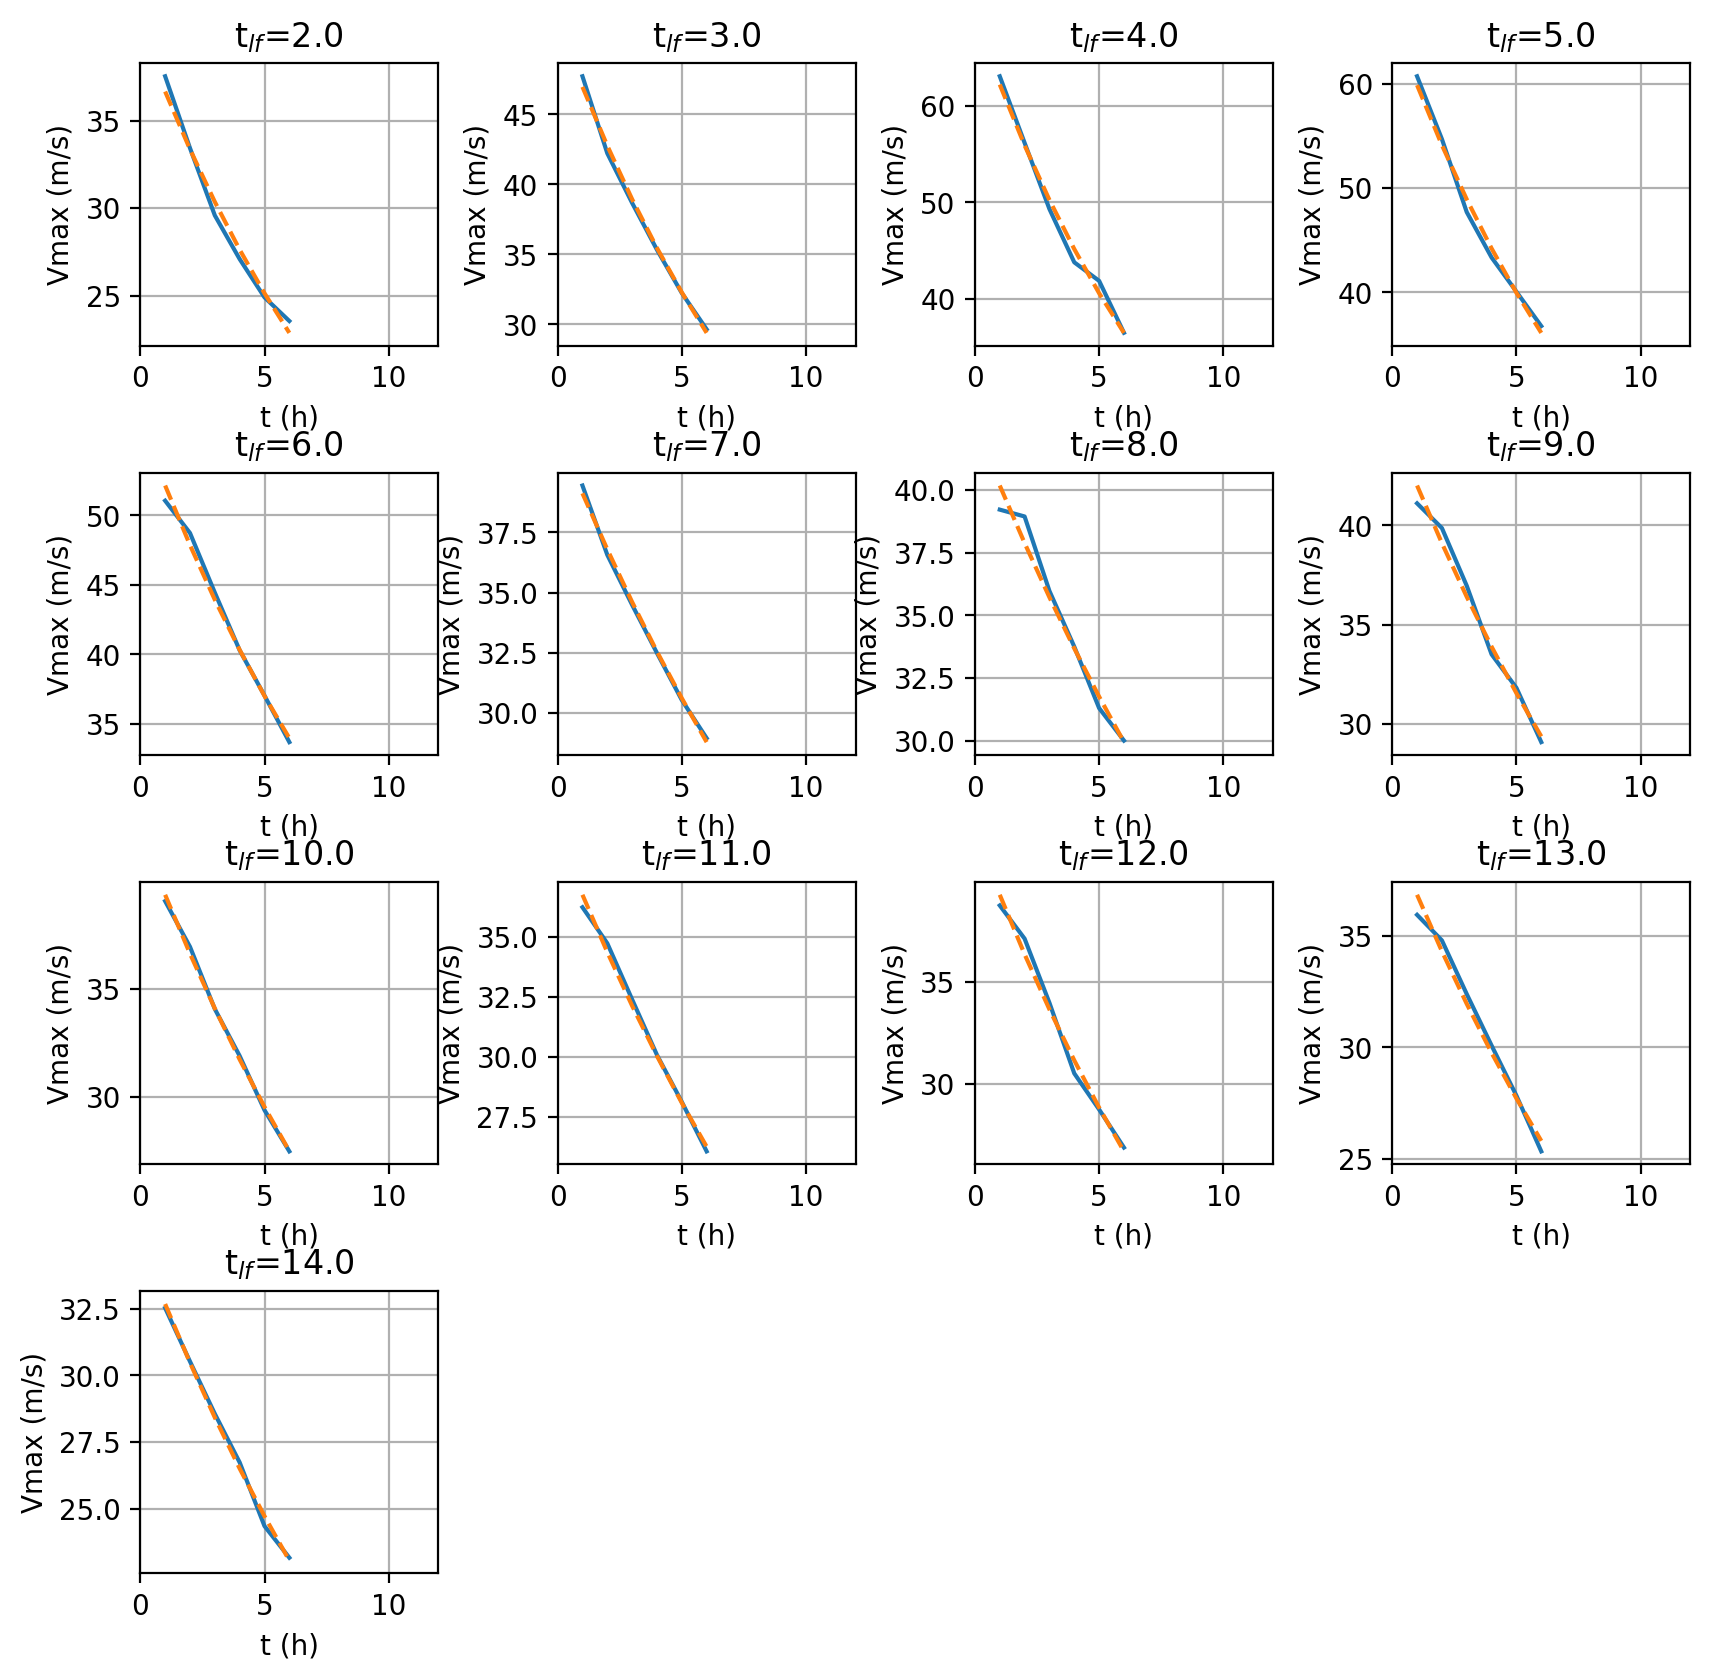

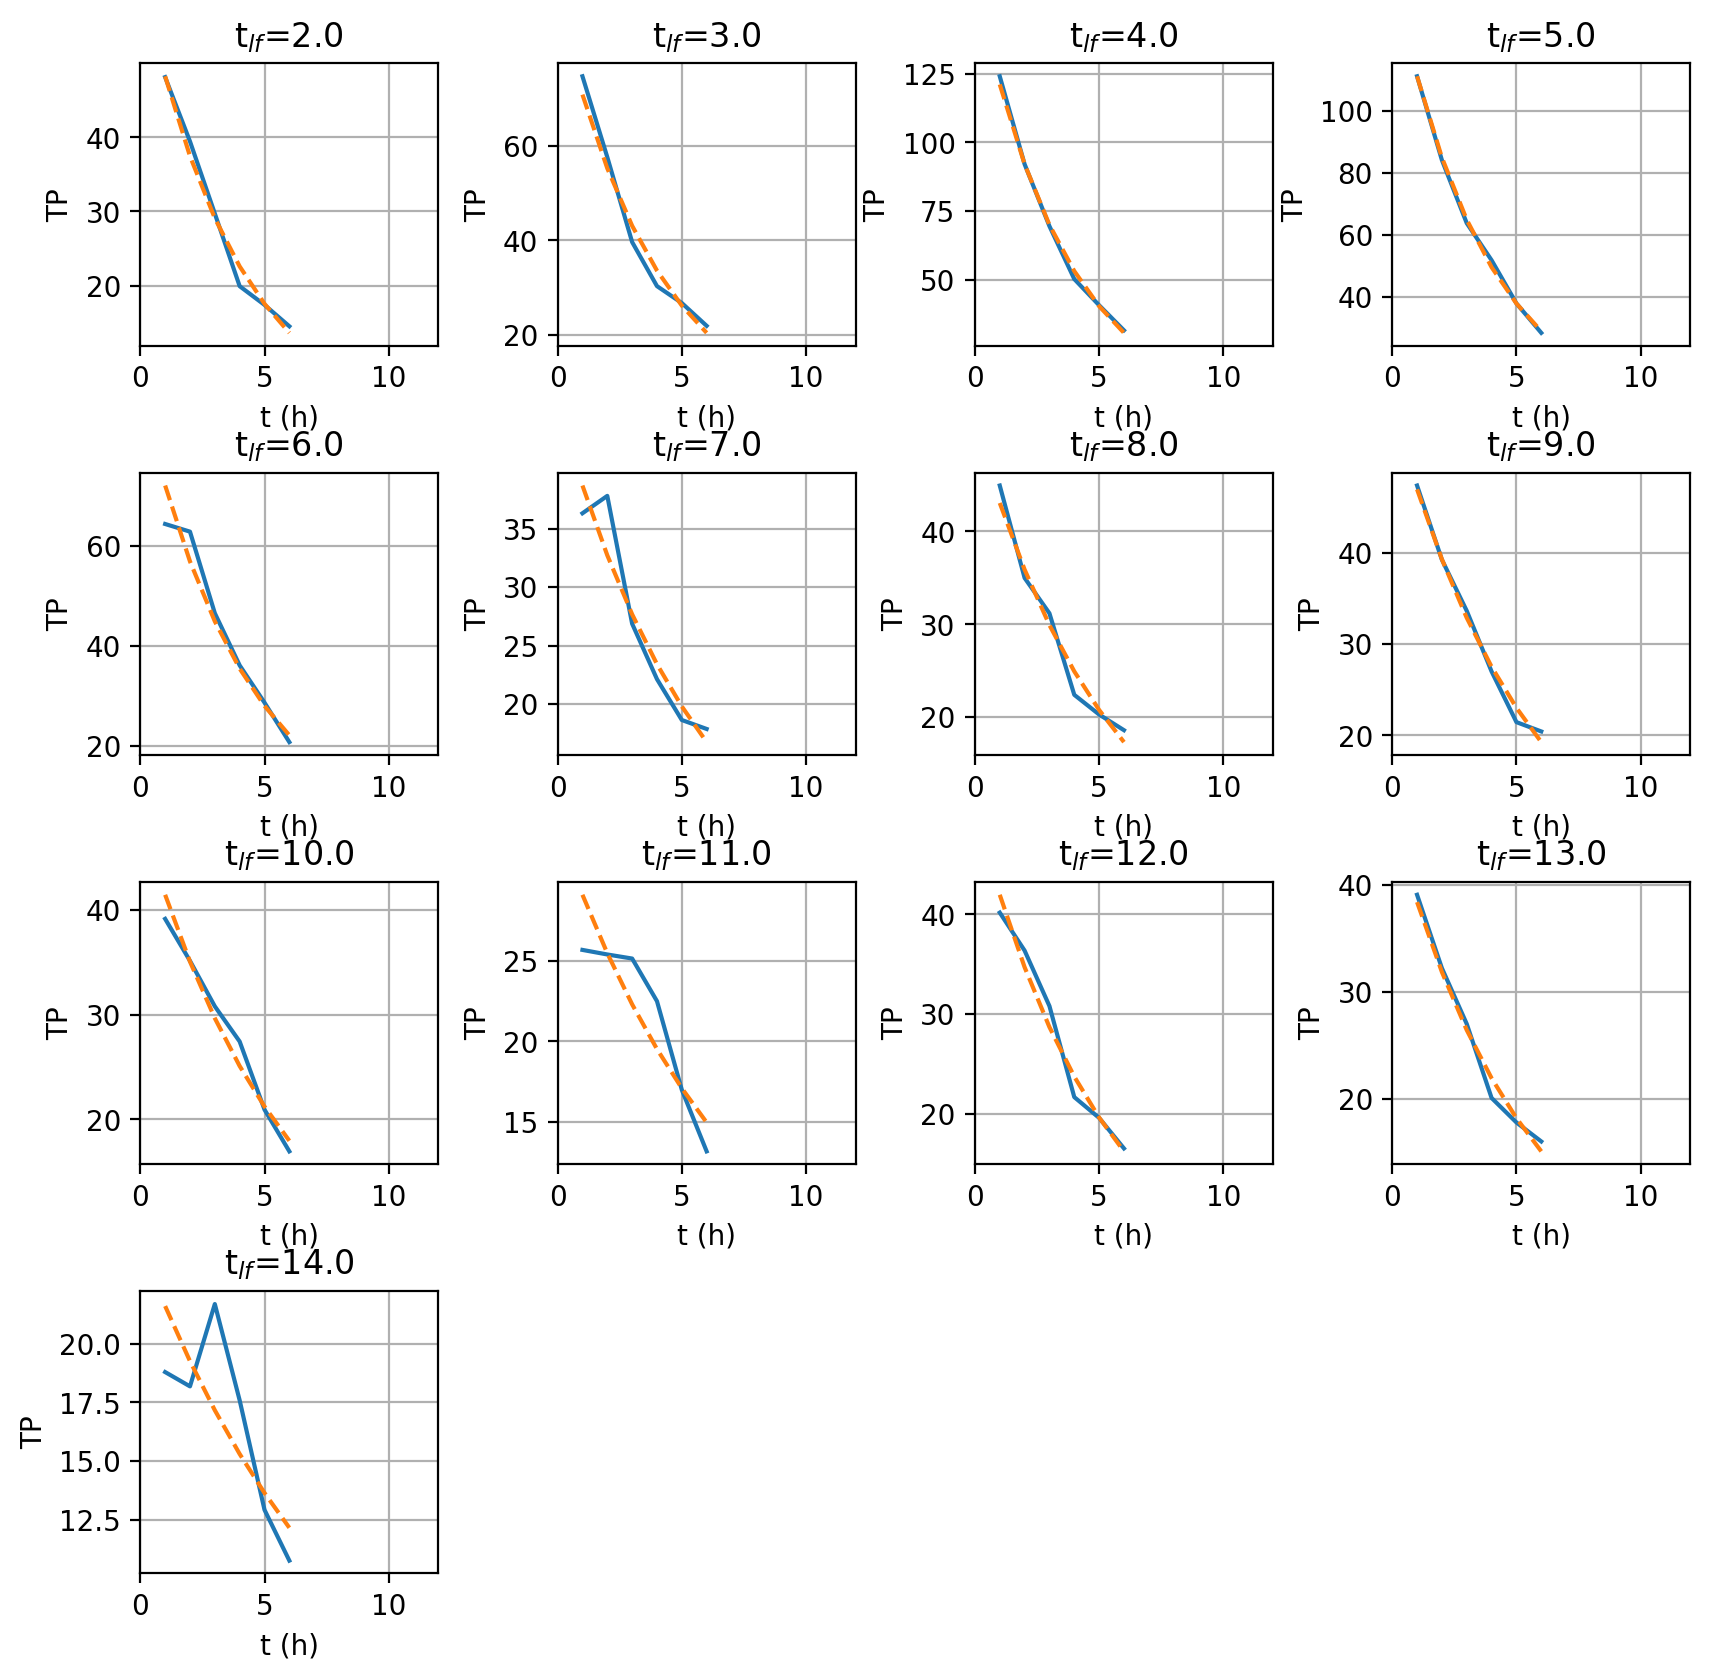

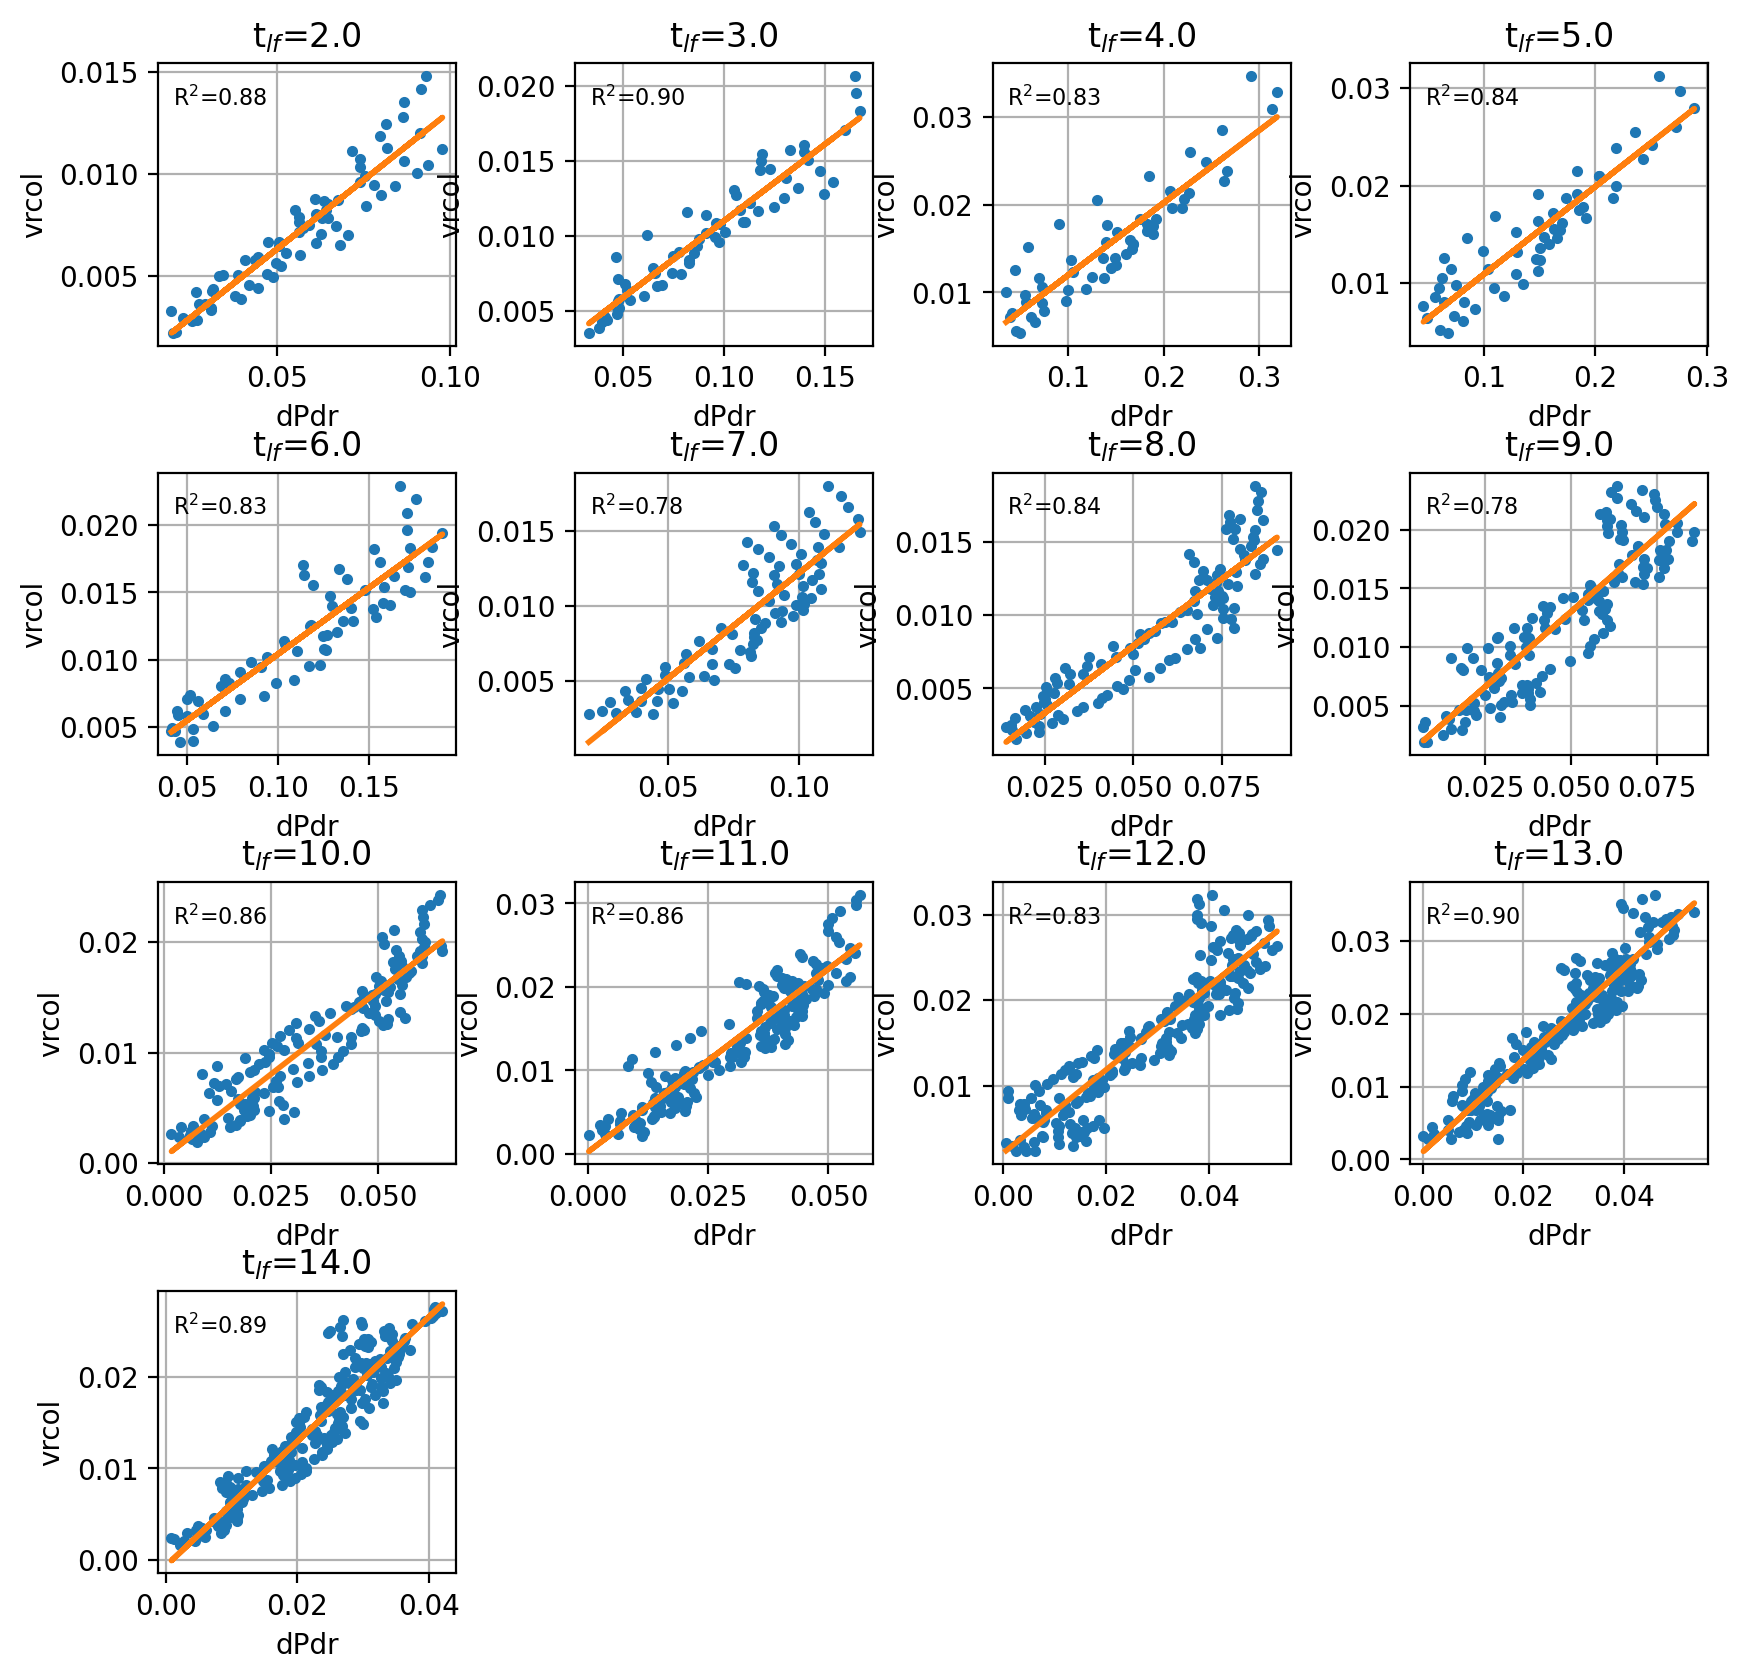

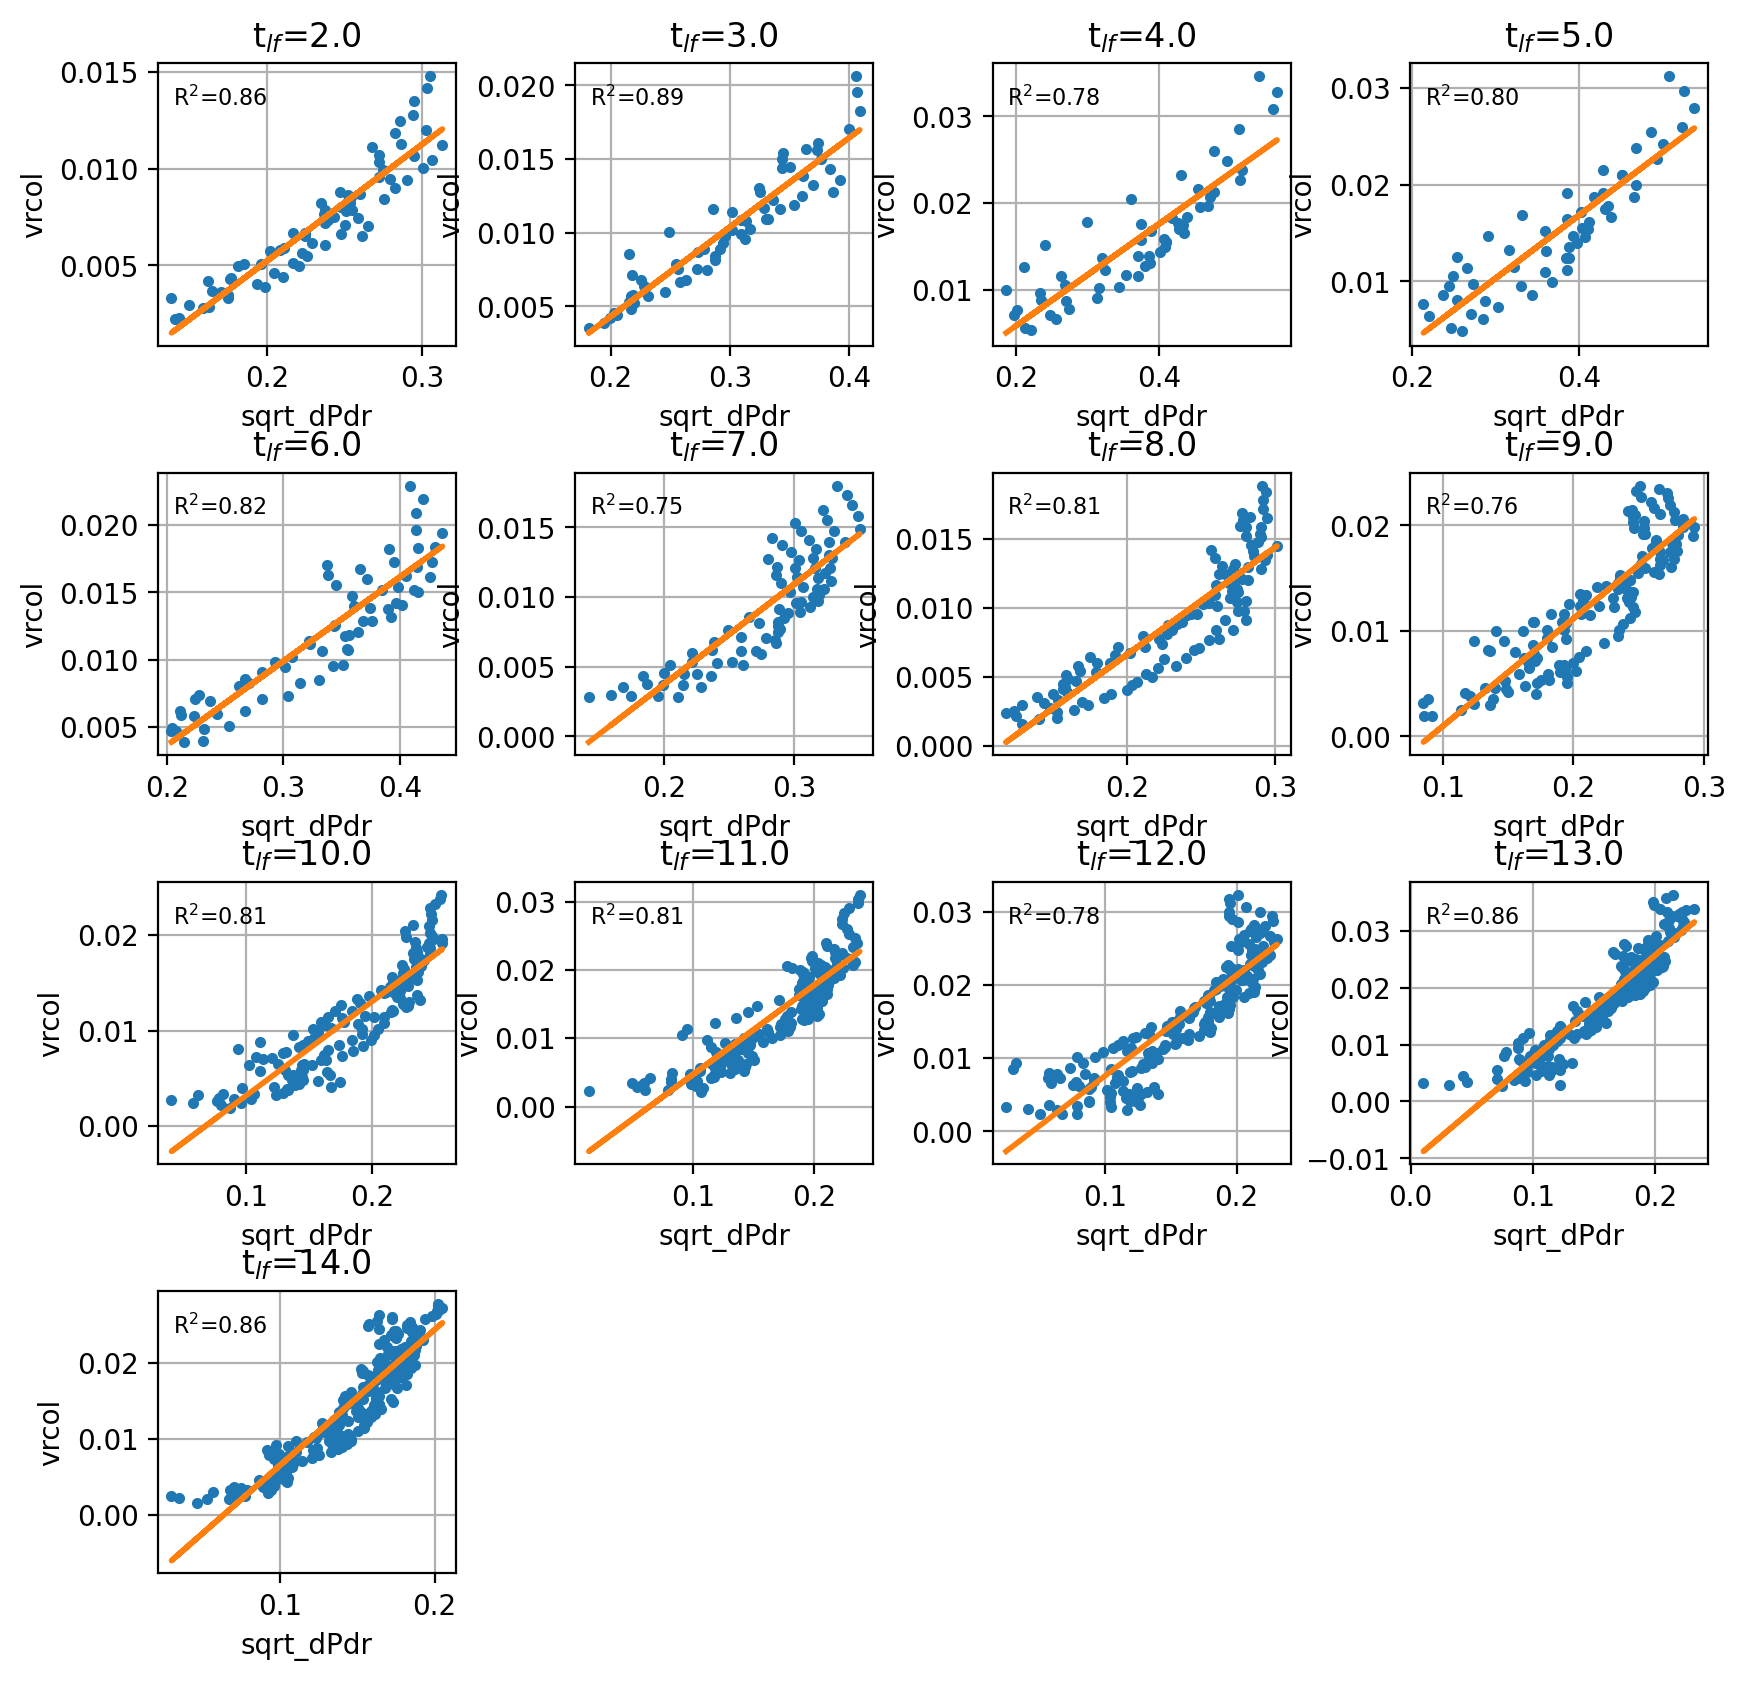

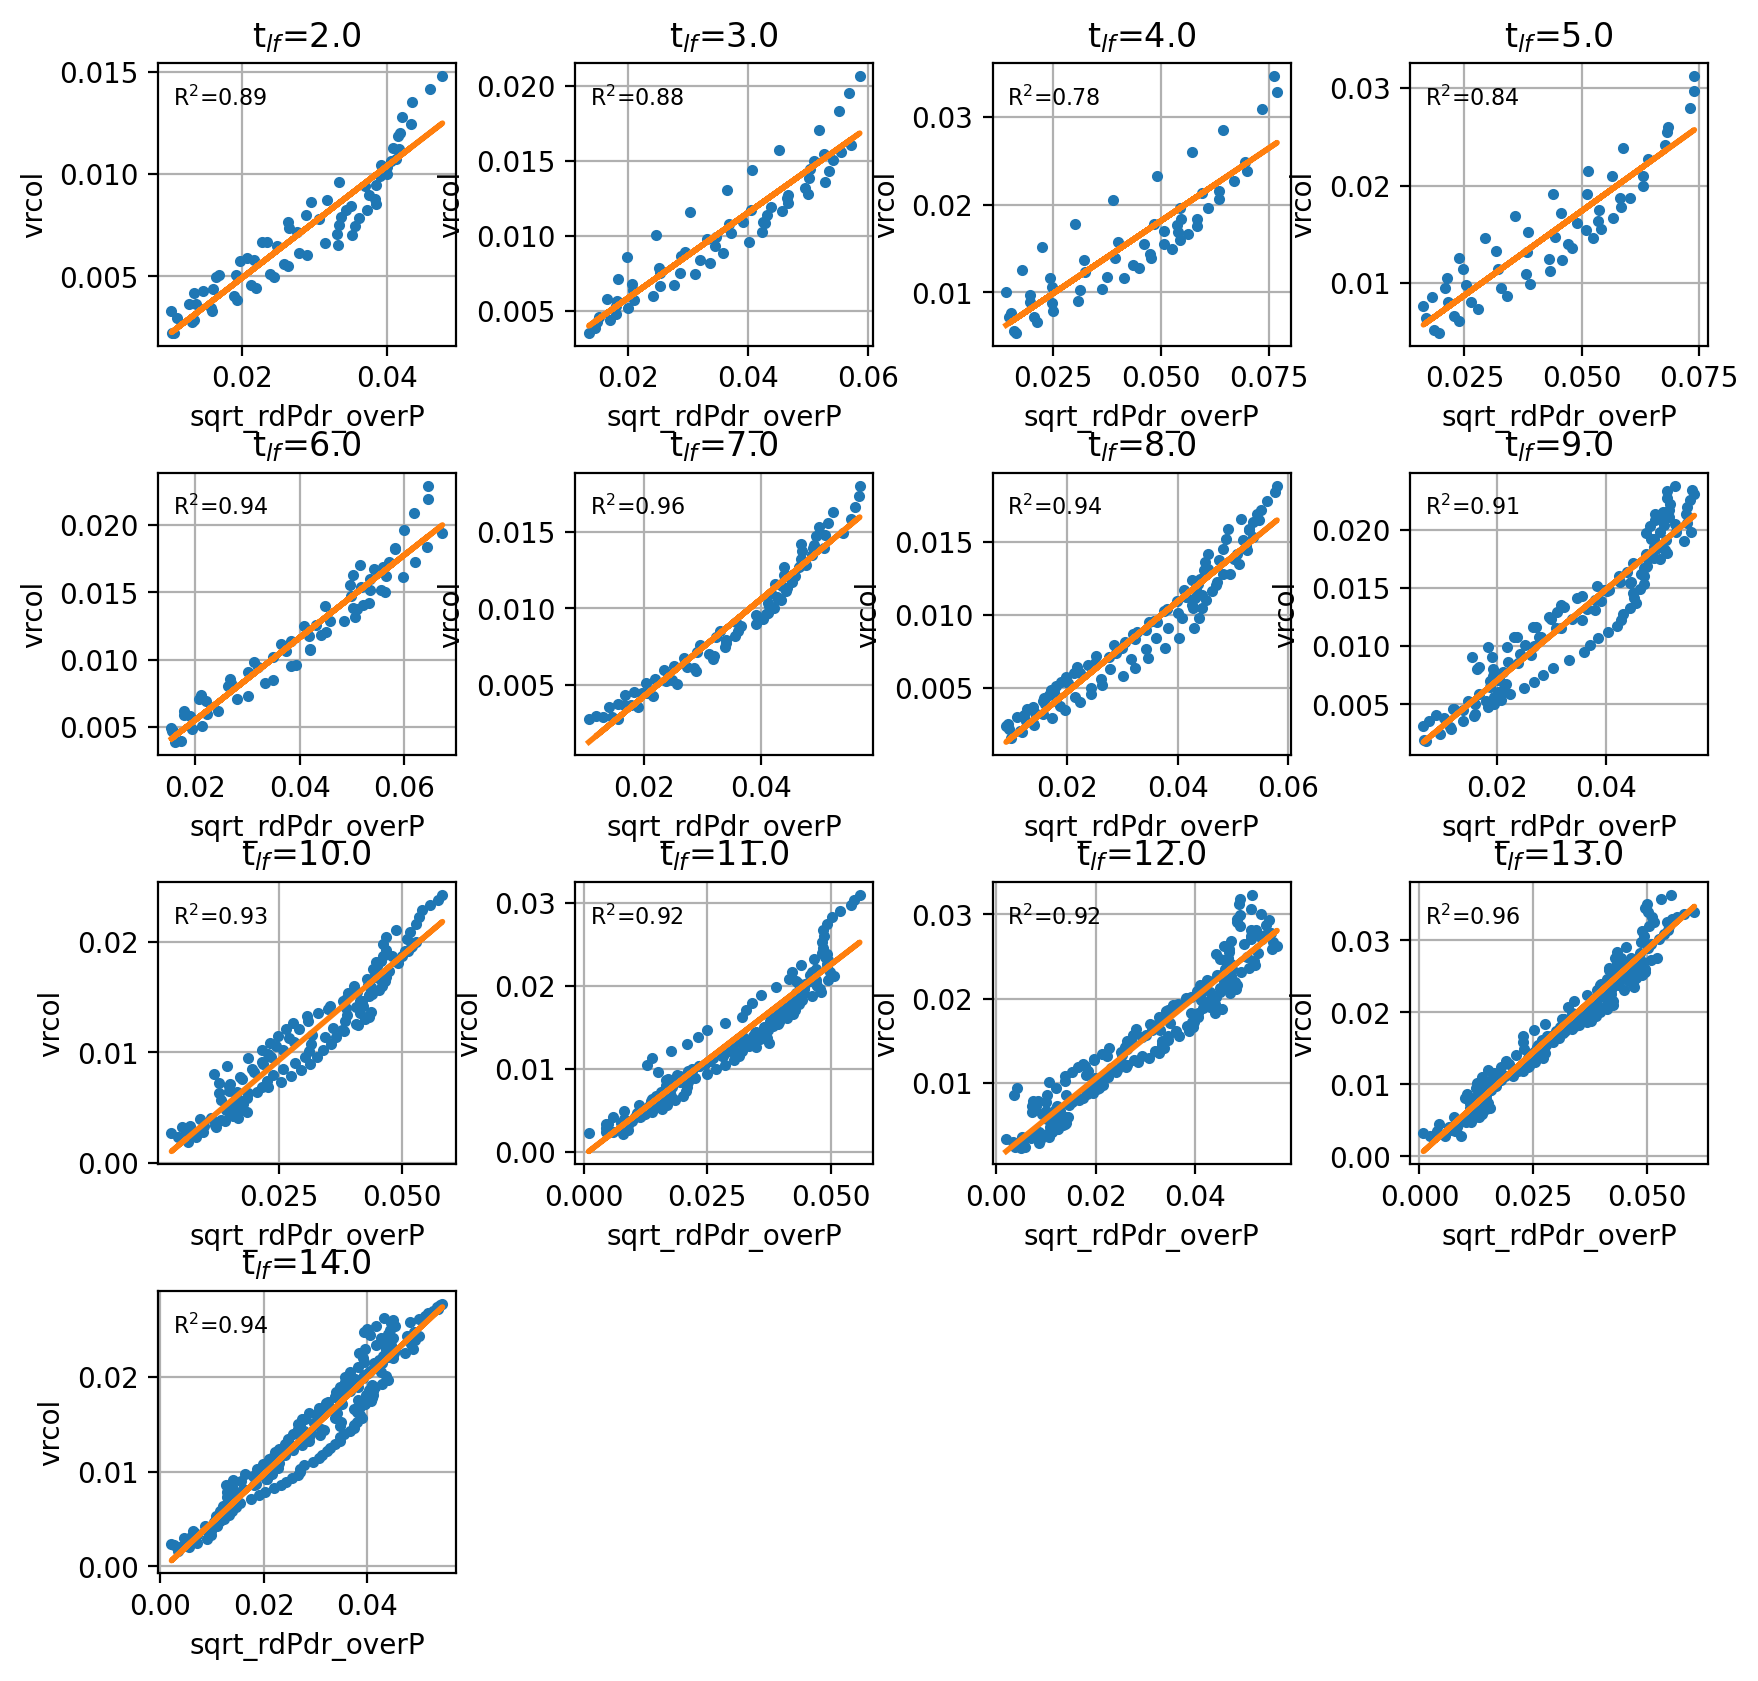

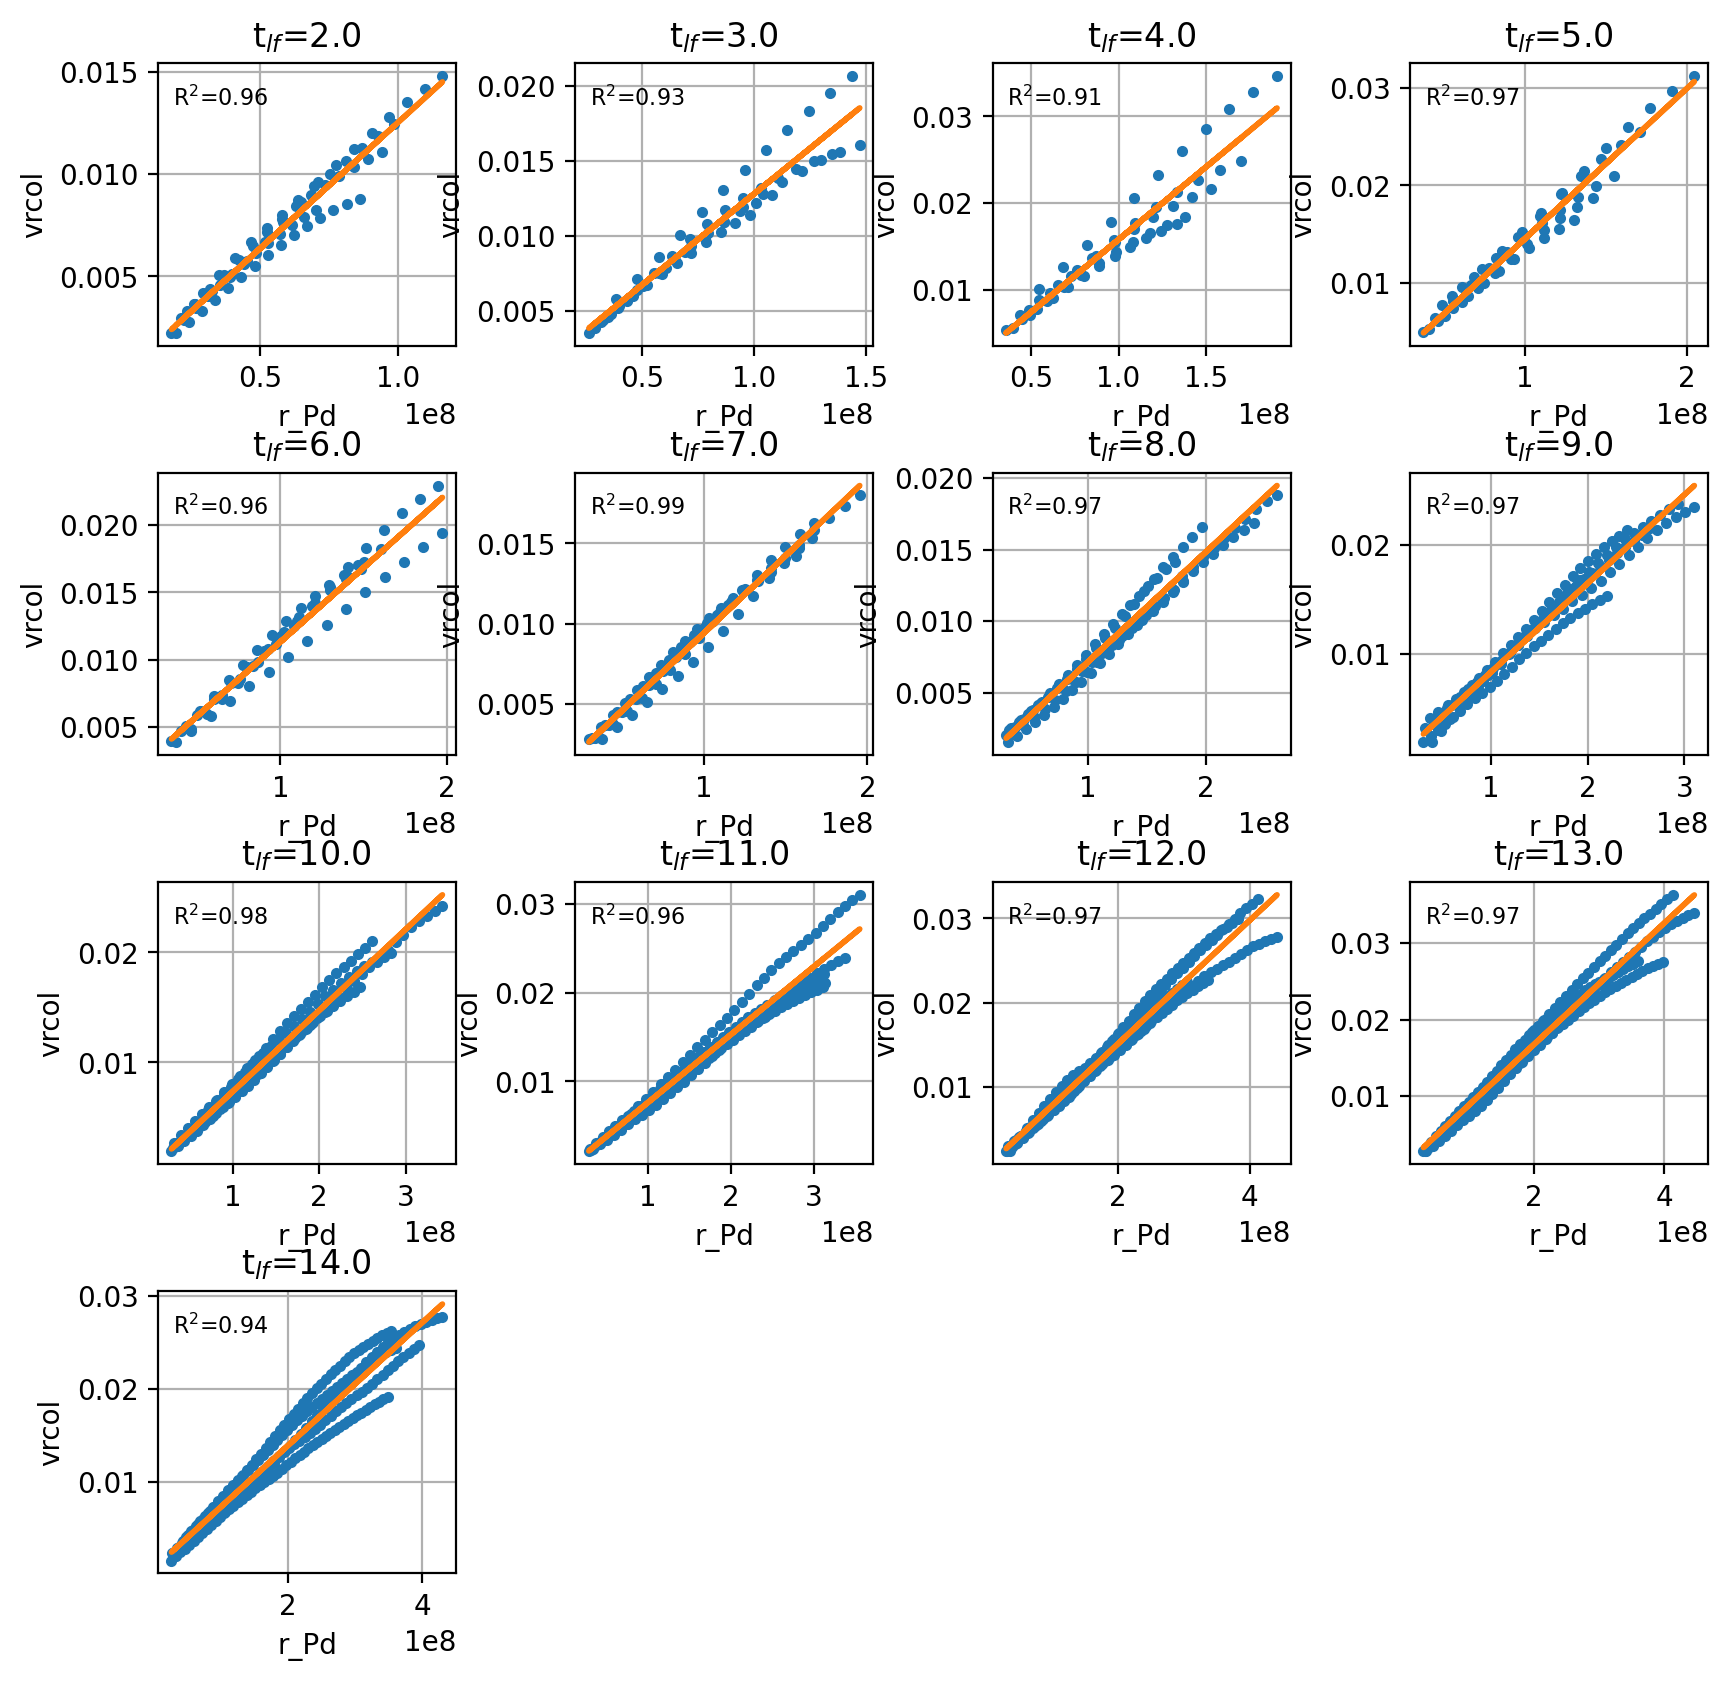

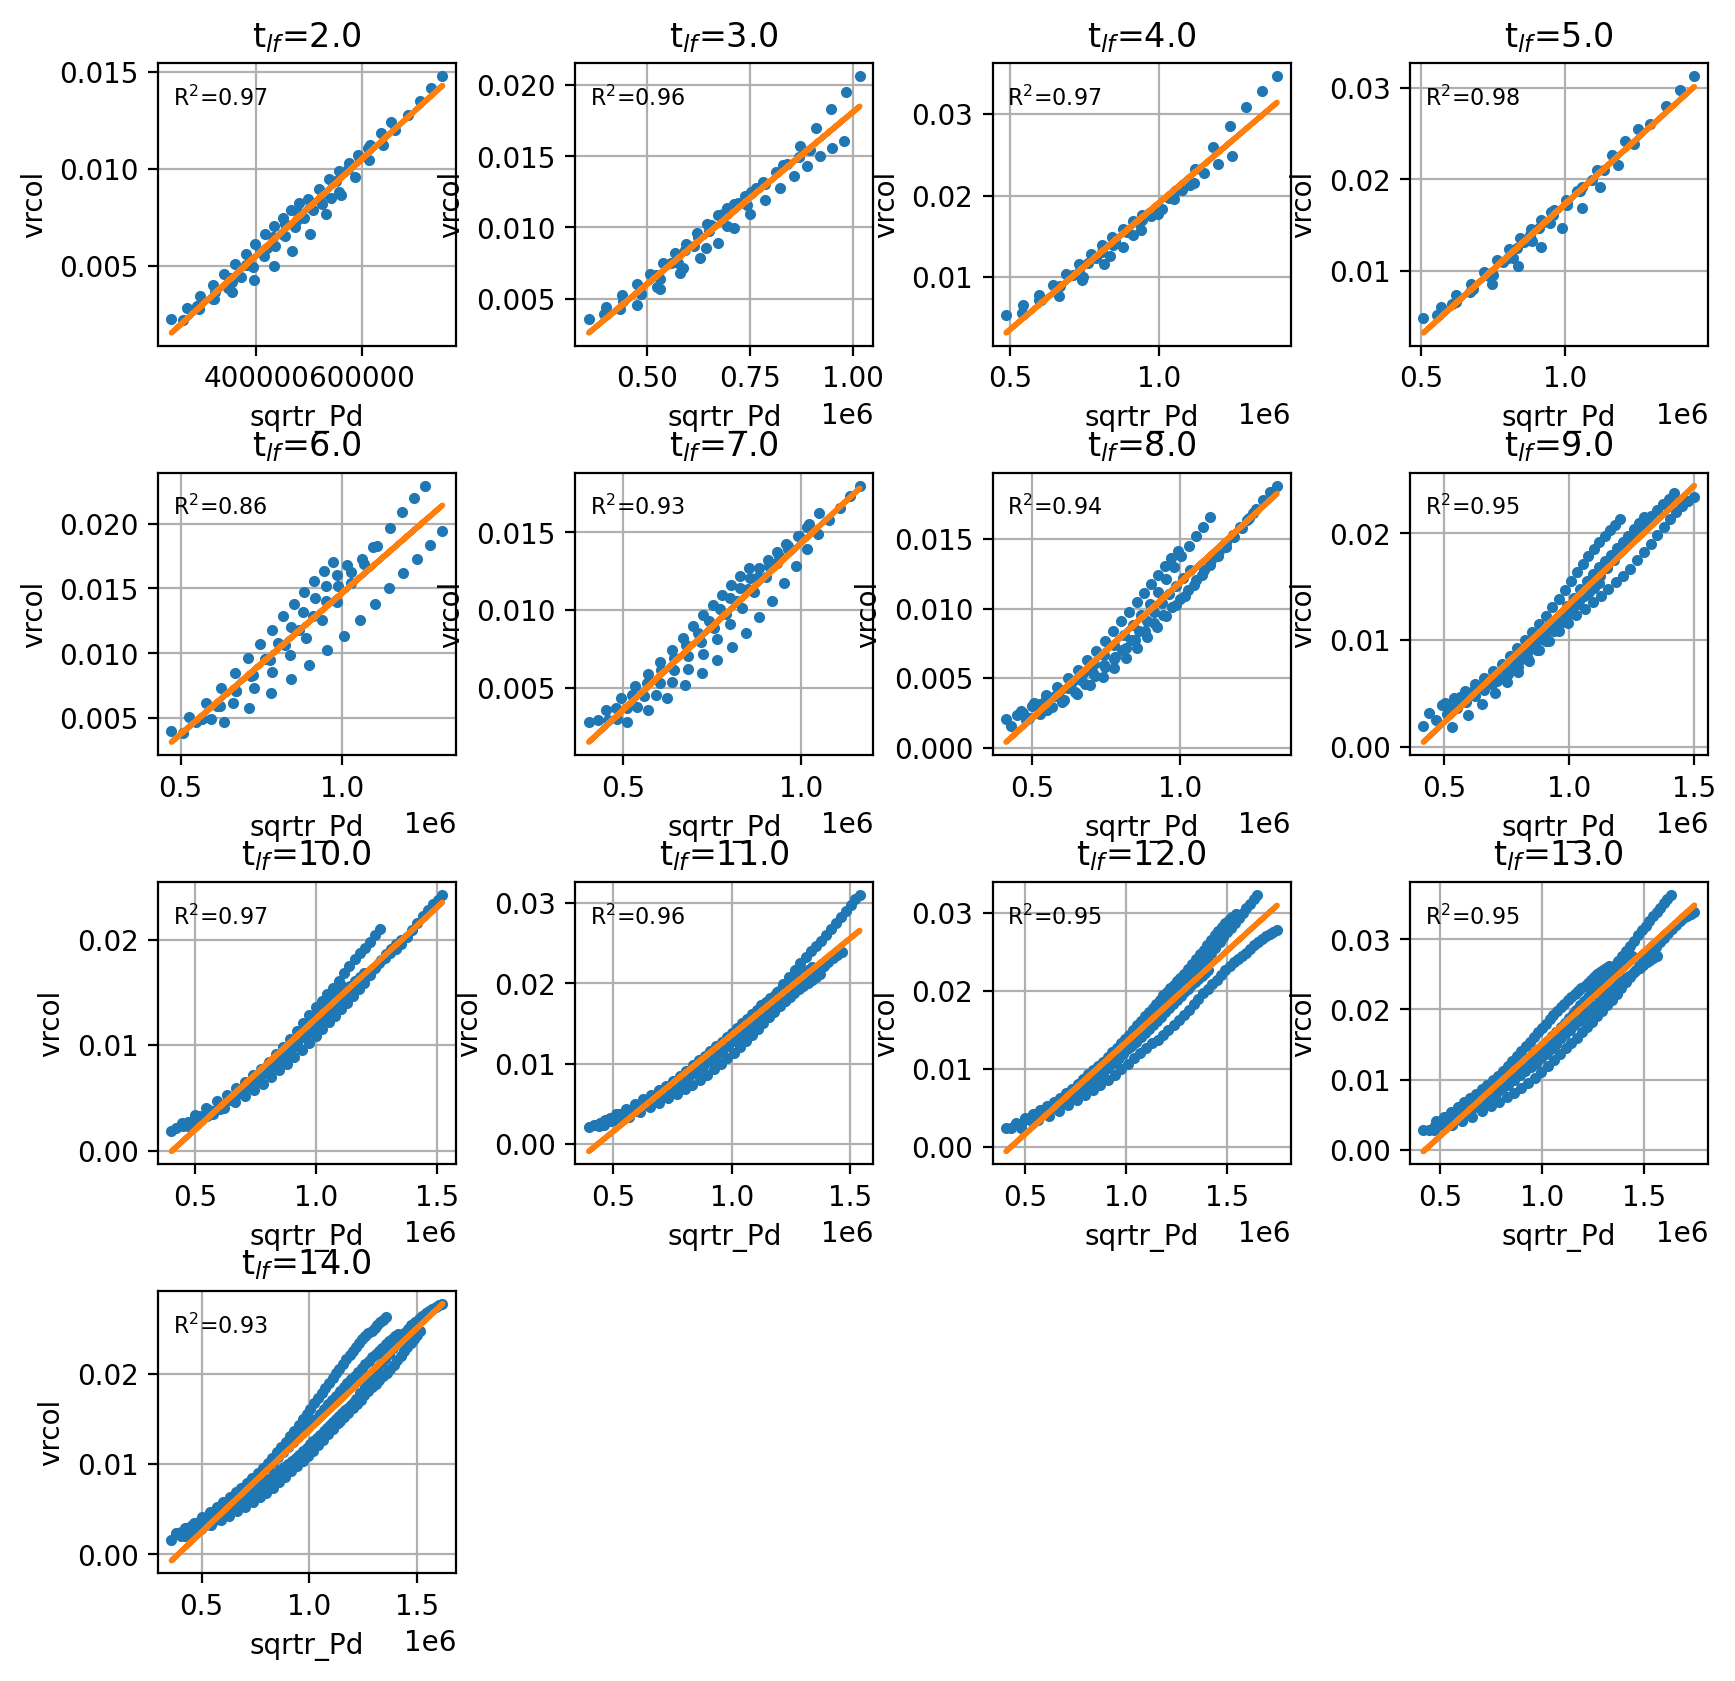

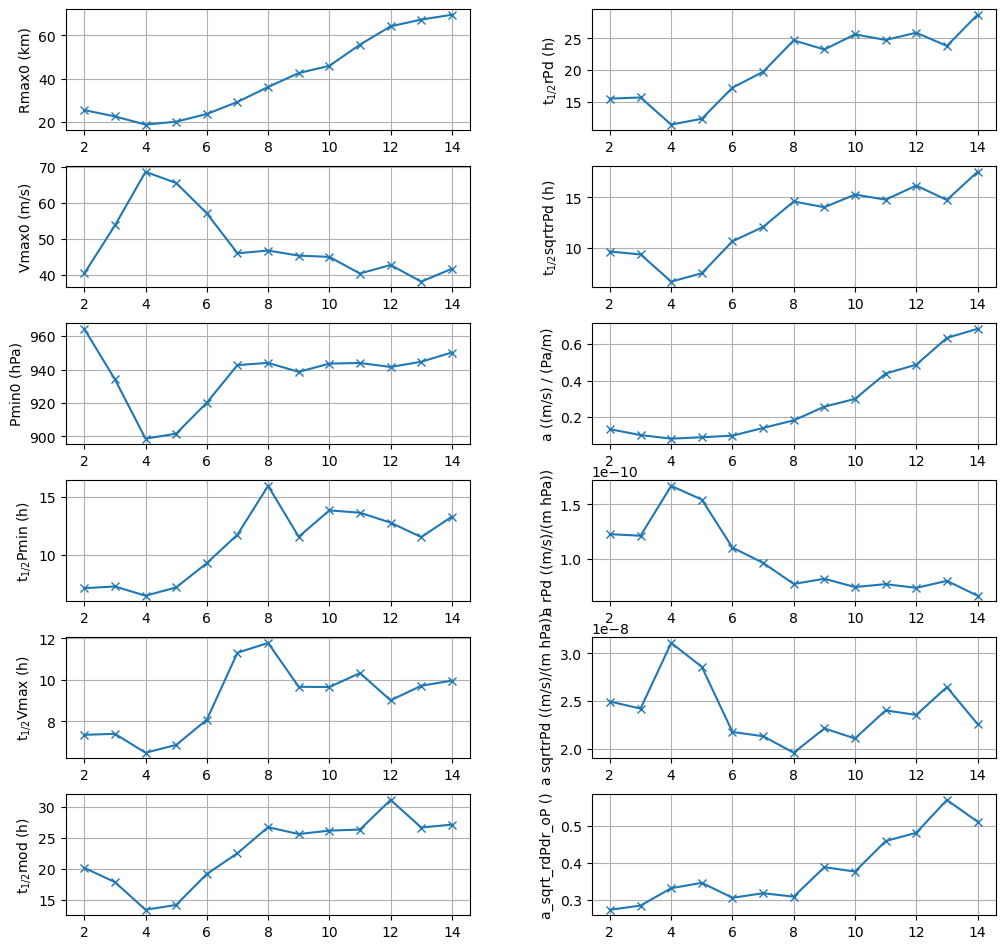

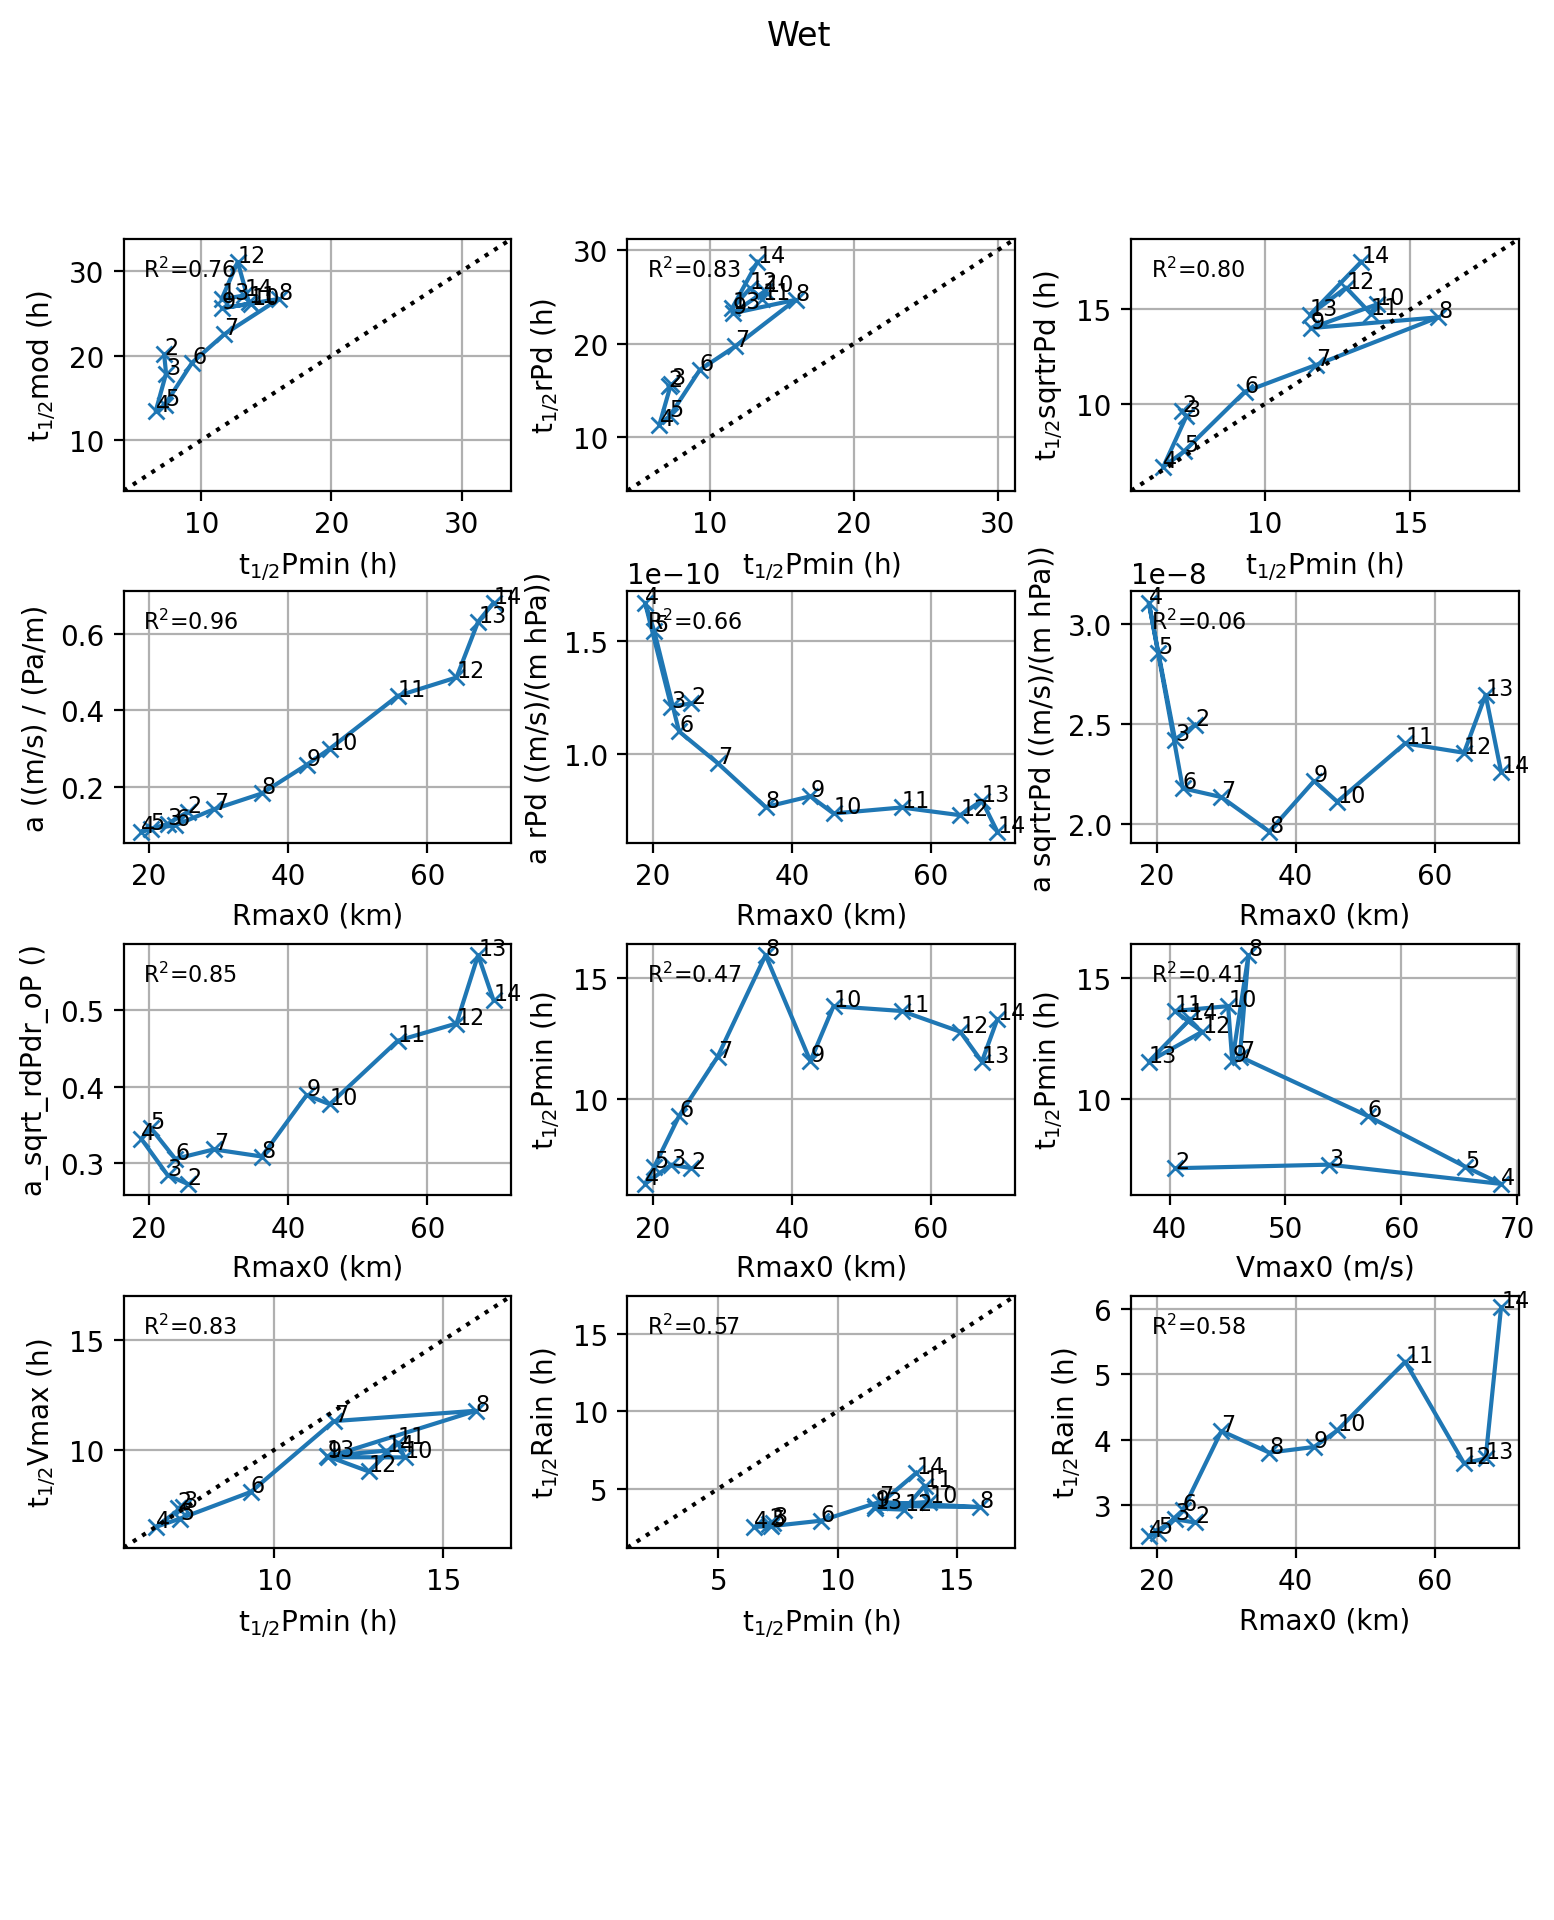

In [52]:
figs=[]; axss=[]
for i in range(8):
    fig,axs=plt.subplots(4,4,sharex=False,dpi=200,figsize=(10,10))
    plt.subplots_adjust(hspace=0.45,wspace=0.4)
    for i in range(len(tlfs),len(axs.flat)):
        axs.flat[i].axis('off')
    figs.append(fig)
    axss.append(axs)
    
fig5,axs5=plt.subplots(6,2,sharex=False,dpi=100,figsize=(12,12))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(len(tlfs),len(axs5.flat)):
    axs5.flat[i].axis('off')

a=[];thP=[];thV=[];thR=[];Rmax0=[];Pmin0=[];Vmax0=[];a_sqrt=[];a_sqrt_rdPdr_oP=[];a_rPd=[];a_sqrtrPd=[];
Pe=1016
tmind=1
tmaxd=6
tmina=1
tmaxa=6
dftab['sqrt_dPdr']=np.sqrt(dftab['dPdr'])
dftab['sqrt_rdPdr_overP']=np.sqrt(dftab['dPdr']*dftab['r']/dftab['P'])
dftab['r_Pd']=1000*dftab['r']*(Pe-dftab['Pmin'])*100
dftab['sqrtr_Pd']=np.sqrt(1000*dftab['r'])*(Pe-dftab['Pmin'])*100


print('Getting vars')
for n,tlf in enumerate(tlfs):
    dftab_f=dftab[dftab.tlf.eq(tlf)]
    df_f=df[df.tlf.eq(tlf)]
    t=df_f.t-df_f.tlf
    Pmin=df_f.Pmin
    Vmax=df_f.V10max
    TP=df_f.tpmax
    Rmax0.append(np.mean(df_f.rV10max.head(6)))
    Vmax0.append(np.mean(df_f.V10max.head(1)))
    Pmin0.append(np.mean(df_f.Pmin.head(1)))
    thP.append(24*fit_thalf(t[tmind:tmaxd+1],Pe-Pmin[tmind:tmaxd+1],ax=axss[0].flat[n],ylab='Pd (hPa)'))
    thV.append(24*fit_thalf(t[tmind:tmaxd+1],Vmax[tmind:tmaxd+1],ax=axss[1].flat[n],ylab='Vmax (m/s)'))
    if runstr=='Wet':
        thR.append(24*fit_thalf(t[tmind:tmaxd+1],TP[tmind:tmaxd+1],ax=axss[2].flat[n],ylab='TP'))
    a.append(get_a_coeff(dftab,tlf,ax=axss[3].flat[n],tmin=tmina,tmax=tmaxa))
    a_sqrt.append(get_a_coeff(dftab,tlf,ax=axss[4].flat[n],tmin=tmina,tmax=tmaxa,xvar='sqrt_dPdr'))
    a_sqrt_rdPdr_oP.append(get_a_coeff(dftab,tlf,ax=axss[5].flat[n],tmin=tmina,tmax=tmaxa,xvar='sqrt_rdPdr_overP'))
    a_rPd.append(get_a_coeff(dftab,tlf,ax=axss[6].flat[n],tmin=tmina,tmax=tmaxa,xvar='r_Pd'))
    a_sqrtrPd.append(get_a_coeff(dftab,tlf,ax=axss[7].flat[n],tmin=tmina,tmax=tmaxa,xvar='sqrtr_Pd'))

print('Calculating half lives')

tha=[calc_thalf(Rmax*1000,az,Pe*100,Pmin*100)/(60*60) for Rmax,az,Pmin in zip (Rmax0,a,Pmin0)]
tha_rPd=[calc_thalf_rPd(a_rPdz,Pe*100)/(60*60) for a_rPdz in a_rPd]
tha_sqrtrPd=[calc_thalf_sqrtrPd(Rmax*1000,a_sqrtrPdz,Pe*100)/(60*60) for Rmax,a_sqrtrPdz in zip(Rmax0,a_sqrtrPd)]


vars=(
    Var('rmax',Rmax0,'Rmax0 (km)'),
    Var('vmax',Vmax0,'Vmax0 (m/s)'),
    Var('pmin ',Pmin0,'Pmin0 (hPa)'),
    Var('thP',thP,'t$_{1/2}$Pmin (h)'),
    Var('thV',thV,'t$_{1/2}$Vmax (h)'),
    Var('tha',tha,'t$_{1/2}$mod (h)'),
    Var('tha_rPd',tha_rPd,'t$_{1/2}$rPd (h)'),
    Var('tha_sqrtrPd',tha_sqrtrPd,'t$_{1/2}$sqrtrPd (h)'),
    Var('a',a,'a ((m/s) / (Pa/m)'),
    Var('a_rPd',a_rPd,'a rPd ((m/s)/(m hPa))'),
    Var('a_sqrtrPd',a_sqrtrPd,'a sqrtrPd ((m/s)/(m hPa))'),
    
    Var('a_sqrt_rdPdr_oP',a_sqrt_rdPdr_oP,'a_sqrt_rdPdr_oP ()'),
)

if runstr=='Wet':
    vars=vars+(Var('thR',thR,'t$_{1/2}$Rain (h)'),)

vd = {var.id: var for var in vars}

print('plotting time series')
axsf=axs5.flatten(order='F')
for ax,d in zip(axsf,vars):
    plot_ts(ax,d)


print('plotting scatters')
fs=8
fig,axs=plt.subplots(5,3,dpi=200,figsize=(9,11))
plt.subplots_adjust(hspace=0.4,wspace=0.3)
        
pltdats=(
    Pltdat(vd['thP'],vd['tha'],True),
    Pltdat(vd['thP'],vd['tha_rPd'],True),    
    Pltdat(vd['thP'],vd['tha_sqrtrPd'],True),
    
    Pltdat(vd['rmax'],vd['a'],False),
    Pltdat(vd['rmax'],vd['a_rPd'],False),
    Pltdat(vd['rmax'],vd['a_sqrtrPd'],False),
    Pltdat(vd['rmax'],vd['a_sqrt_rdPdr_oP'],False),

    Pltdat(vd['rmax'],vd['thP'],False),
    Pltdat(vd['vmax'],vd['thP'],False),
    Pltdat(vd['thP'],vd['thV'],True),
 
)

if runstr=='Wet':
    pltdats=pltdats+(
        Pltdat(vd['thP'],vd['thR'],True),
        Pltdat(vd['rmax'],vd['thR'],False),
)

for ax,pltdat in zip(axs.flatten(),pltdats):
    plot_scat(ax,pltdat)
plt.suptitle(runstr);
for i in range(len(pltdats),len(axs.flat)):
    axs.flat[i].axis('off')